In [52]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from datetime import datetime
from sklearn.decomposition import PCA

#파일 읽어오기
df = pd.read_csv("C:/JUPTTER/[DArt-B 5기] Global_Supermarket.csv")

# 한글 폰트 설정 
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       51290 non-null  object 
 1   customer_name     51290 non-null  object 
 2   customer_segment  51290 non-null  object 
 3   order_id          51290 non-null  object 
 4   order_city        51290 non-null  object 
 5   oreder_region     51290 non-null  object 
 6   order_date        51290 non-null  object 
 7   order_year        51290 non-null  int64  
 8   order_weeknum     51290 non-null  int64  
 9   quantity          51290 non-null  int64  
 10  sales             51290 non-null  int64  
 11  product_id        51290 non-null  object 
 12  product_name      51290 non-null  object 
 13  profit            51290 non-null  float64
 14  discount          51290 non-null  float64
 15  category          51290 non-null  object 
 16  sub_category      51290 non-null  object

In [54]:
#데이터의 내용을 확인, 첫번째 ROW 출력
df.head(1)

,customer_id,customer_name,customer_segment,order_id,order_city,oreder_region,order_date,order_year,order_weeknum,quantity,...,discount,category,sub_category,market_country,market_area,market_city,ship_date,ship_mode,shipping_cost,row_id
0,LS-172304,Lycoris Saunders,Consumer,CA-2019-130813,Los Angeles,West,2019-01-07,2019,2,3,...,0.0,Office Supplies,Paper,United States,US,California,2019-01-09,Second Class,4.37,36624


RFM 데이터 예시:
  customer_id  recency  frequency  monetary
0   AA-103151        9          5      1445
1   AA-103152       14          7      6105
2   AA-103153      695          2       633
3   AA-103154      185          5      5565
4   AA-103751        7          4      2407

클러스터별 평균 RFM 값:
            recency  frequency     monetary
cluster                                    
0        140.778741   4.273276  1511.757256
1         95.143964   8.369916  5238.622983
2        730.116244   2.162444   771.365127


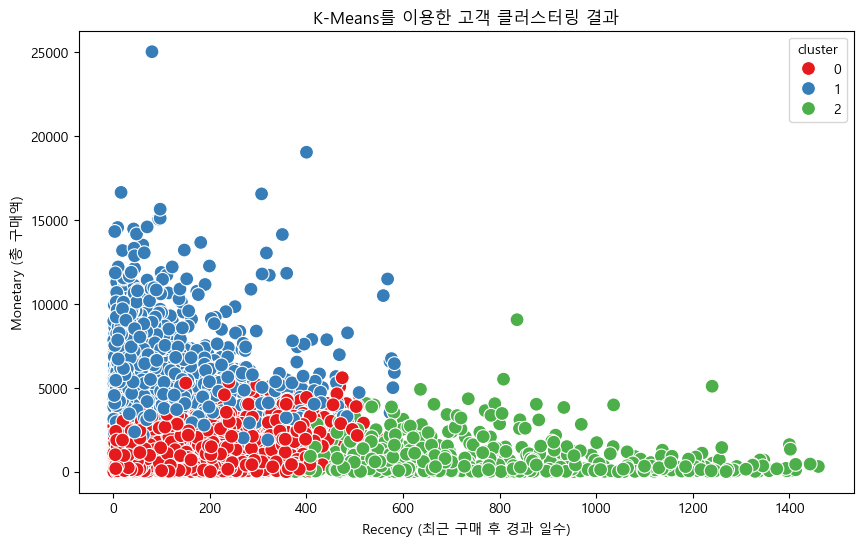

In [55]:
#  order_date를 datetime 형식으로 변환 (오류 발생 시 NaT 처리)
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

#  분석 기준 날짜 설정: 데이터 내 마지막 주문일 + 1일
analysis_date = df['order_date'].max() + pd.DateOffset(days=1)

# 고객별 RFM 지표 집계
# - Recency: 각 고객의 마지막 주문일과 기준 날짜 사이의 일수
# - Frequency: 고객별 고유 주문 건수 (order_id의 고유값 개수)
# - Monetary: 고객별 총 소비 금액 (sales 합계)
rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (analysis_date - x.max()).days,
    'order_id': 'nunique',
    'sales': 'sum'
}).rename(columns={
    'order_date': 'recency',
    'order_id': 'frequency',
    'sales': 'monetary'
}).reset_index()

print("RFM 데이터 예시:")
print(rfm.head())

#  RFM 지표 스케일링 (recency, frequency, monetary만)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])

# K-Means 클러스터링: 고객을 3개의 그룹으로 분할
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)

# 클러스터별 특성 확인 (수치형 데이터만 선택)
cluster_summary = rfm[['recency', 'frequency', 'monetary', 'cluster']].groupby('cluster').mean()
print("\n클러스터별 평균 RFM 값:")
print(cluster_summary)

# 클러스터 시각화 
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='recency', y='monetary', hue='cluster', palette='Set1', s=100)
plt.title('K-Means를 이용한 고객 클러스터링 결과')
plt.xlabel('Recency (최근 구매 후 경과 일수)')
plt.ylabel('Monetary (총 구매액)')
plt.show()




In [39]:
# 데이터 준비
df['order_date'] = pd.to_datetime(df['order_date'])
df['days_since'] = (df['order_date'] - df['order_date'].min()).dt.days  # 날짜를 정수로 변환
features = ['days_since', 'sales']

# 데이터 스케일링
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

# 실루엣 점수 계산
silhouette_scores = {}
for k in range(2, 8):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_scaled)  # 전체 데이터에 대한 클러스터링

    score = silhouette_score(df_scaled, cluster_labels)  # 전체 데이터셋에 대한 실루엣 점수 계산
    silhouette_scores[k] = score
    print(f"클러스터개수: {k}, 실루엣점수: {score:.4f}")


클러스터개수: 2, 실루엣점수: 0.4835
클러스터개수: 3, 실루엣점수: 0.5308
클러스터개수: 4, 실루엣점수: 0.4306
클러스터개수: 5, 실루엣점수: 0.4231
클러스터개수: 6, 실루엣점수: 0.4292
클러스터개수: 7, 실루엣점수: 0.4500


In [56]:
# 사용할 컬럼 선택
numeric_columns = ['sales']  # 'order_date', 'order_id' 제외
categorical_columns = ['category', 'sub_category', 'market_country', 'market_area', 'quantity']

# 날짜 처리
df['days_since'] = (df['order_date'] - df['order_date'].min()).dt.days
numeric_columns.append('days_since')

# 수치형 데이터 타입 변경
df[numeric_columns] = df[numeric_columns].astype(np.float32)

# 범주형 데이터 원-핫 인코딩
encoder = OneHotEncoder(sparse_output=True, drop='first')
encoded_categorical = encoder.fit_transform(df[categorical_columns])

# 변환된 원-핫 인코딩된 컬럼명 생성
encoded_columns = encoder.get_feature_names_out(categorical_columns)

# 데이터프레임 변환
df_encoded = pd.DataFrame.sparse.from_spmatrix(encoded_categorical, columns=encoded_columns)

# 수치형 데이터 스케일링
scaler = StandardScaler()
df_numeric_scaled = scaler.fit_transform(df[numeric_columns])

# 수치형 데이터프레임 변환
df_numeric = pd.DataFrame(df_numeric_scaled, columns=numeric_columns, index=df.index)

# 수치형 + 원-핫 인코딩 데이터 합치기
df_final = pd.concat([df_numeric, df_encoded], axis=1)



Updated column names: Index(['customer_id', 'customer_name', 'customer_segment', 'order_id',
       'order_city', 'oreder_region', 'order_date', 'order_year',
       'order_weeknum', 'quantity', 'sales', 'product_id', 'product_name',
       'profit', 'discount', 'category', 'sub_category', 'market_country',
       'market_area', 'market_city', 'ship_date', 'ship_mode', 'shipping_cost',
       'row_id', 'days_since', 'Cluster'],
      dtype='object')


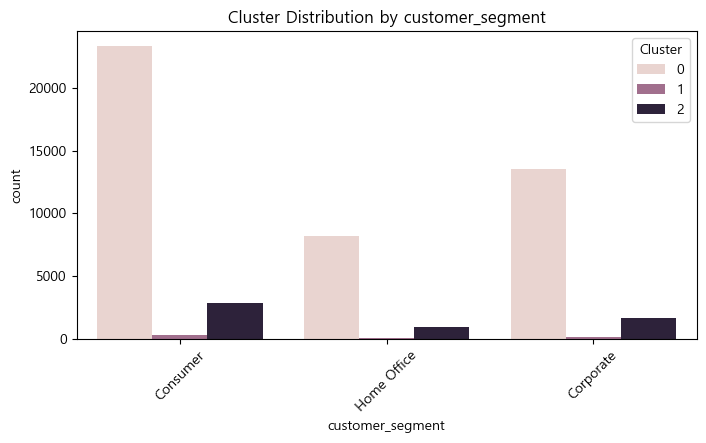

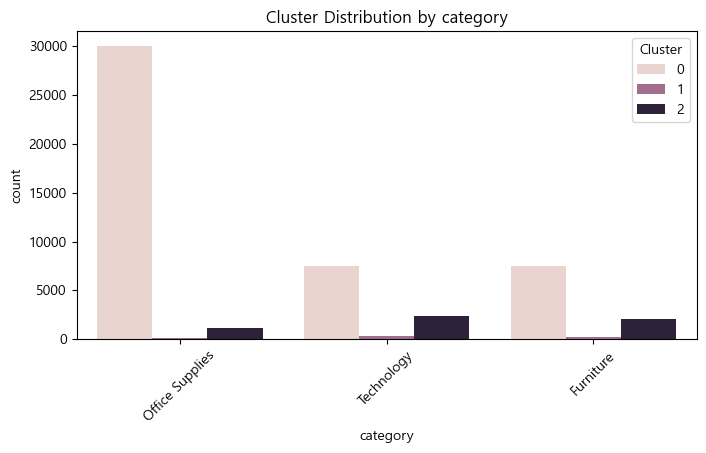

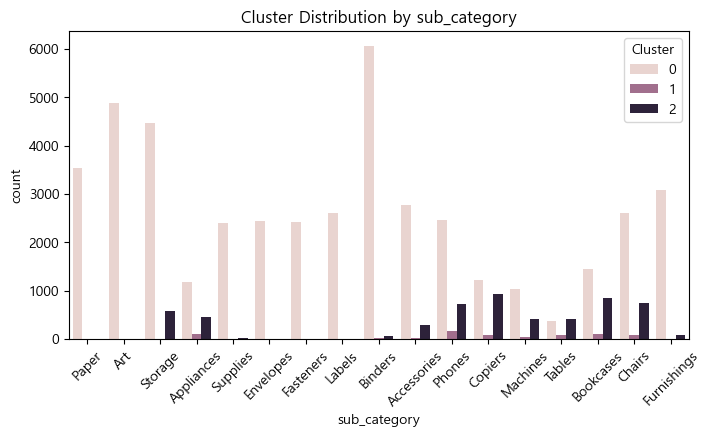

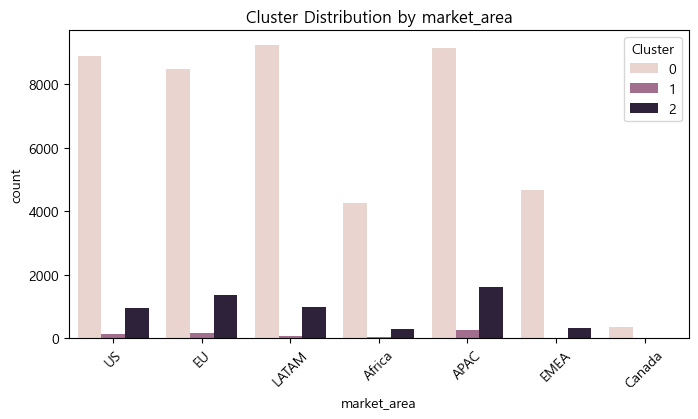

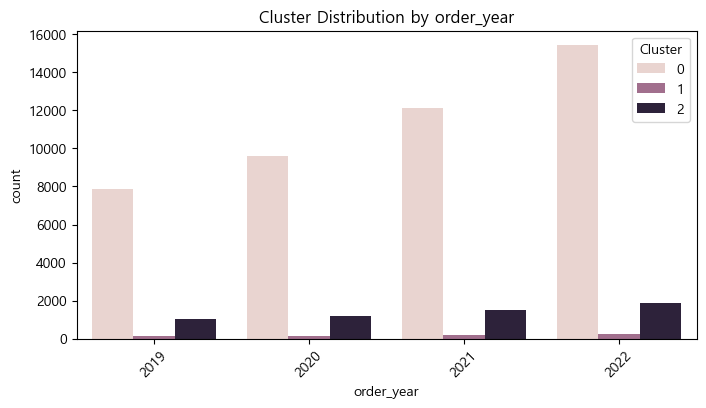

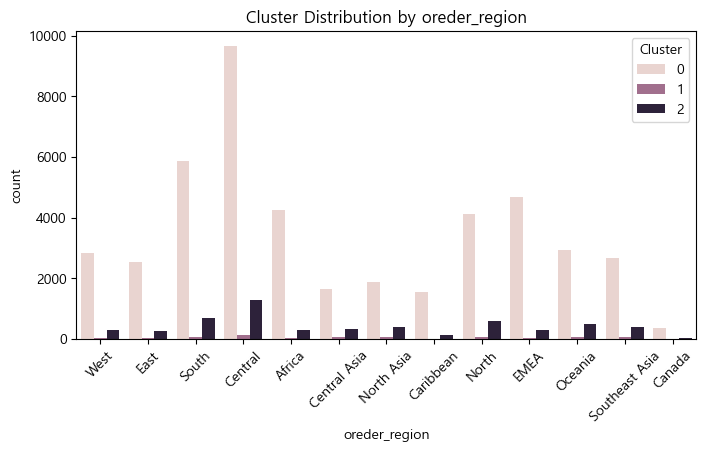

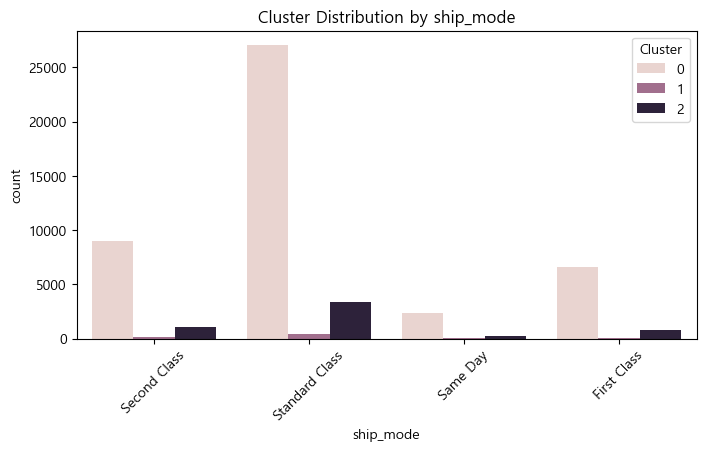

In [61]:
df['sales'] = df['sales'].astype(float)  # sales를 숫자형으로 변환
numeric_features = ['sales'] 
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[numeric_features])

# KMeans 클러스터링 실행
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)  # 클러스터 레이블을 'Cluster' 열에 저장

column_mapping = {
    'customer_segment':'customer_segment',
    'category': 'category',
    'sub_category': 'sub_category',
    'market_country': 'market_country',
    'market_area': 'market_area',
    'order_year':'order_year',
    'oreder_region':'oreder_region',
    'ship_mode':'ship_mode'
}
df.rename(columns=column_mapping, inplace=True)

print("Updated column names:", df.columns)

categorical_columns = [
    'customer_segment',
    'category',
    'sub_category',
    'market_area',
    'order_year',
    'oreder_region',
    'ship_mode'
]

for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='Cluster', data=df)
    plt.title(f'Cluster Distribution by {col}')
    plt.legend(title='Cluster')
    plt.xticks(rotation=45)
    plt.show()


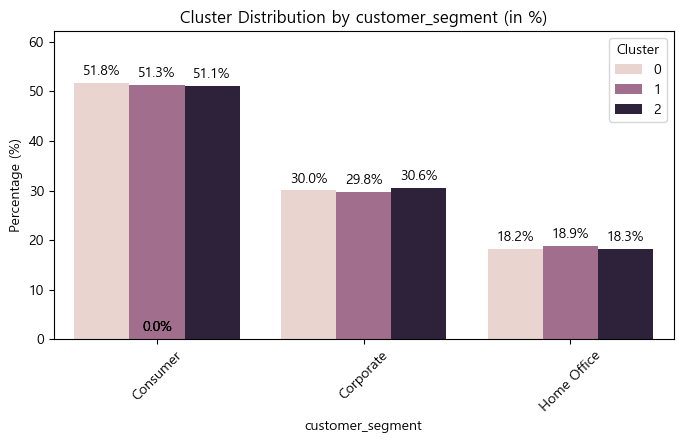

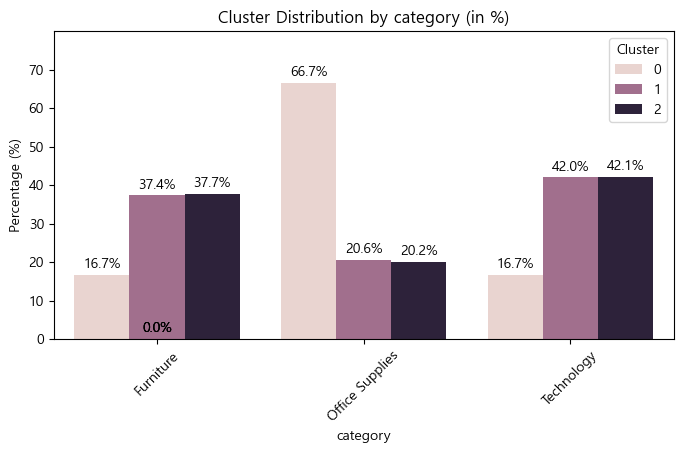

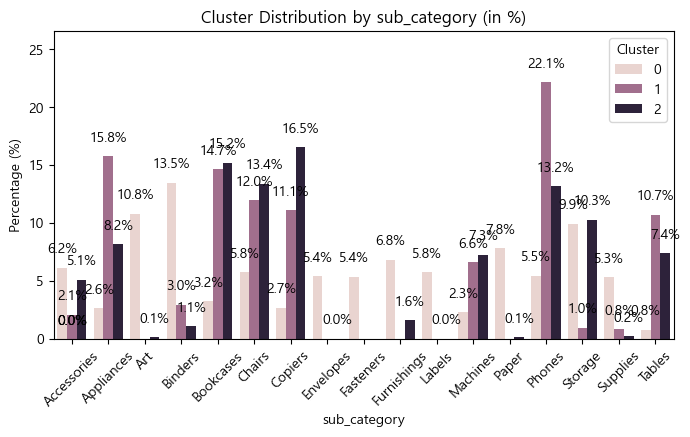

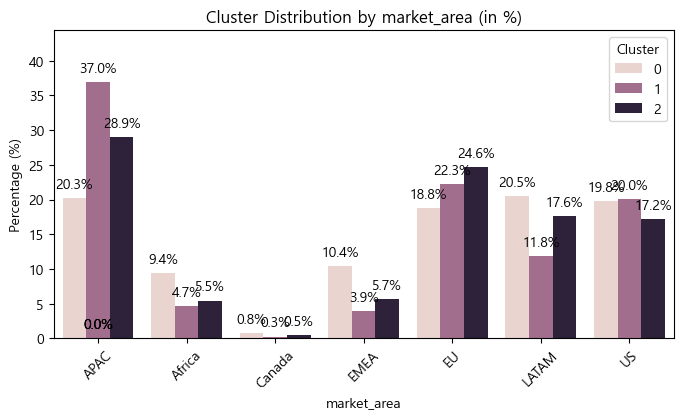

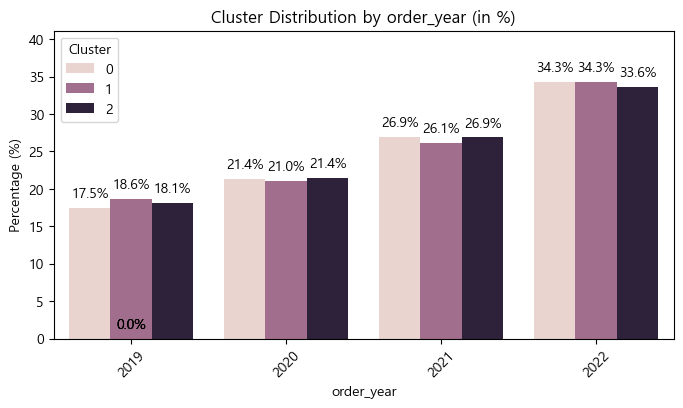

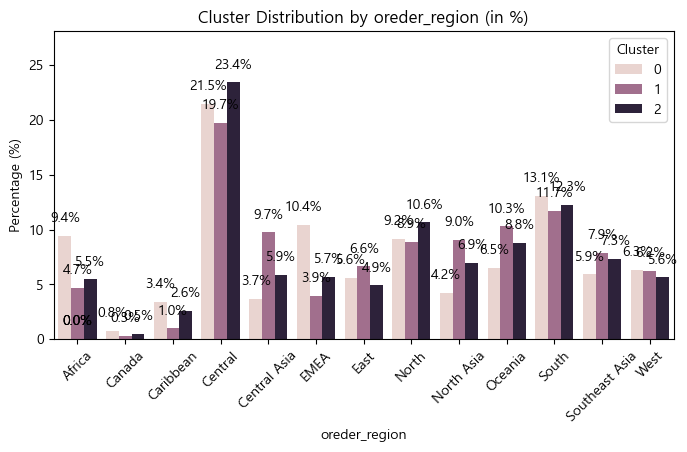

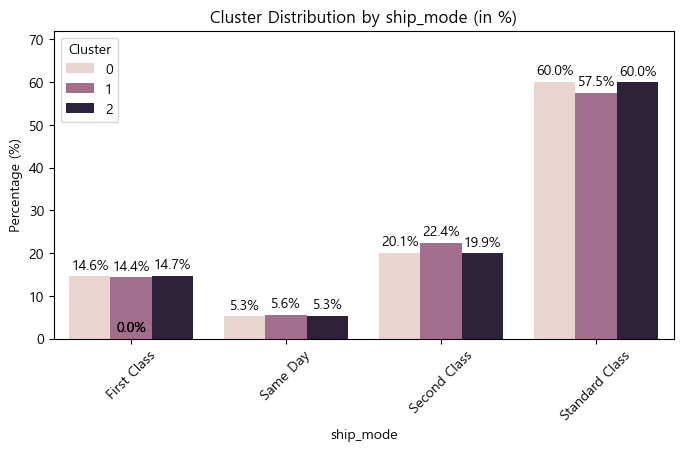

In [63]:
for col in categorical_columns:
    # 각 카테고리 값과 클러스터별 개수를 계산
    grouped = df.groupby([col, 'Cluster']).size().reset_index(name='count')
    
    # 각 클러스터별 전체 개수를 계산
    cluster_totals = df.groupby('Cluster').size().reset_index(name='total')
    
    # 두 데이터를 병합한 후, 비율(%)을 계산
    merged = pd.merge(grouped, cluster_totals, on='Cluster')
    merged['percentage'] = merged['count'] / merged['total'] * 100
    
    # 막대그래프 그리기: x축은 해당 카테고리, y축은 클러스터 내 비율
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(x=col, y='percentage', hue='Cluster', data=merged)
    plt.title(f'Cluster Distribution by {col} (in %)')
    plt.xlabel(col)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    
    #각 막대 위에 퍼센트 수치를 표시
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 1, f'{height:.1f}%', 
                ha="center", va='bottom', fontsize=10)
    
    plt.ylim(0, merged['percentage'].max() * 1.2)
    plt.legend(title='Cluster')
    plt.show()


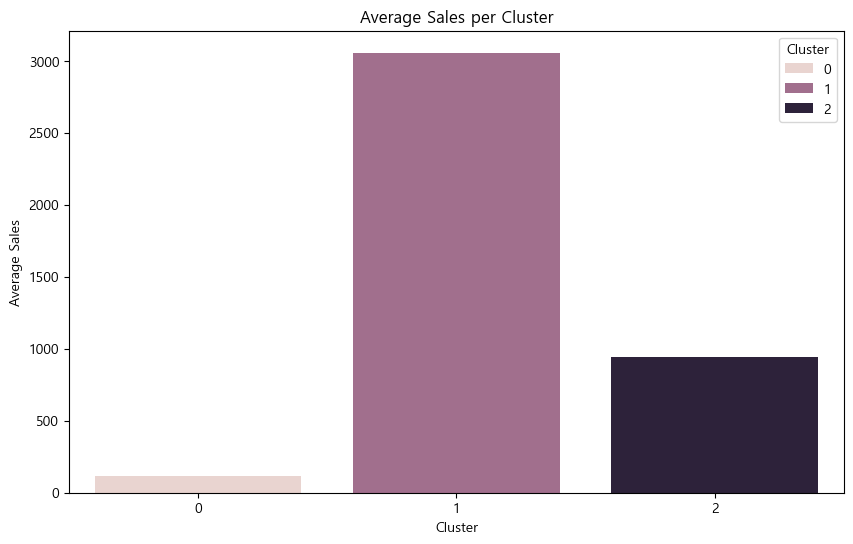

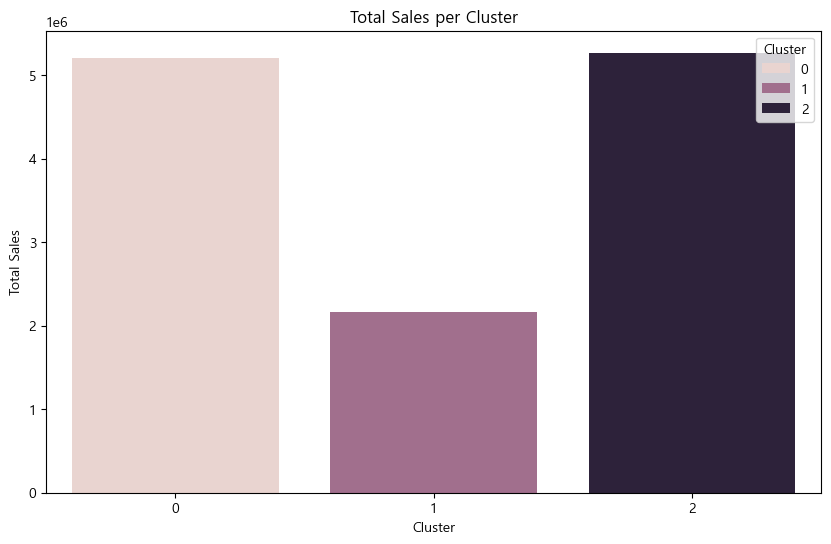

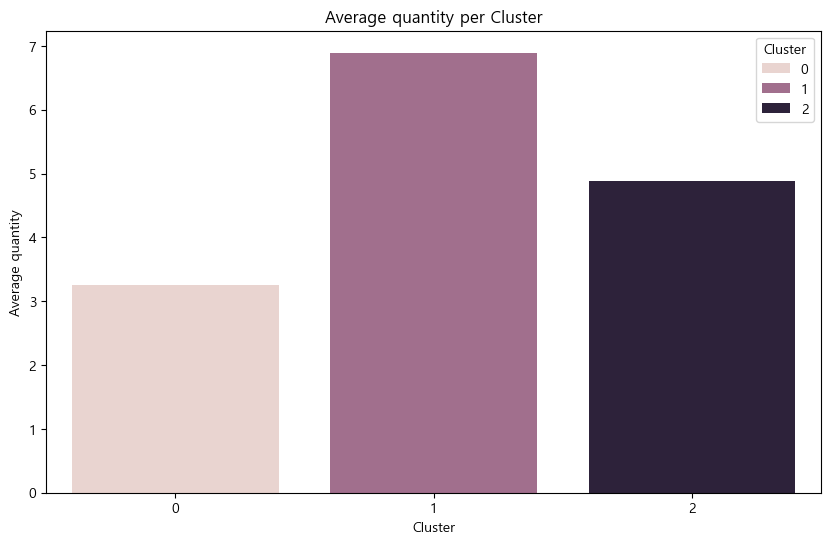

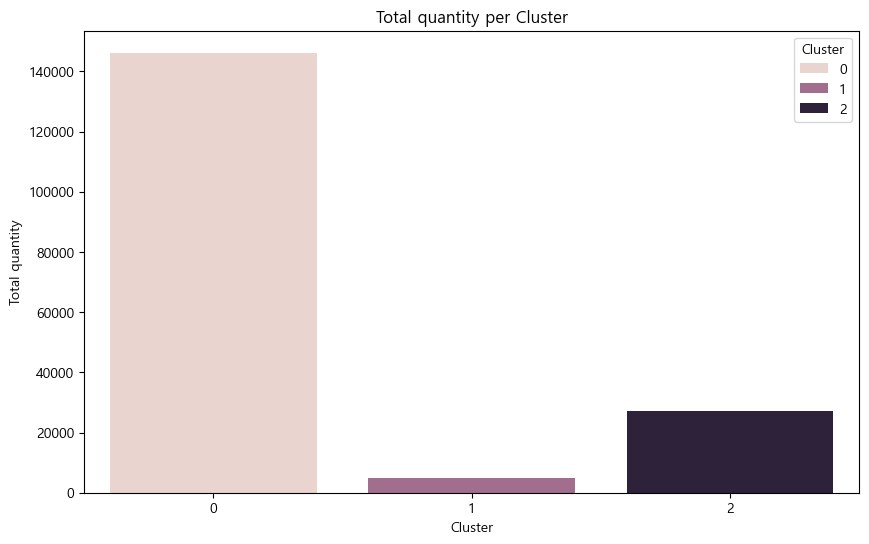

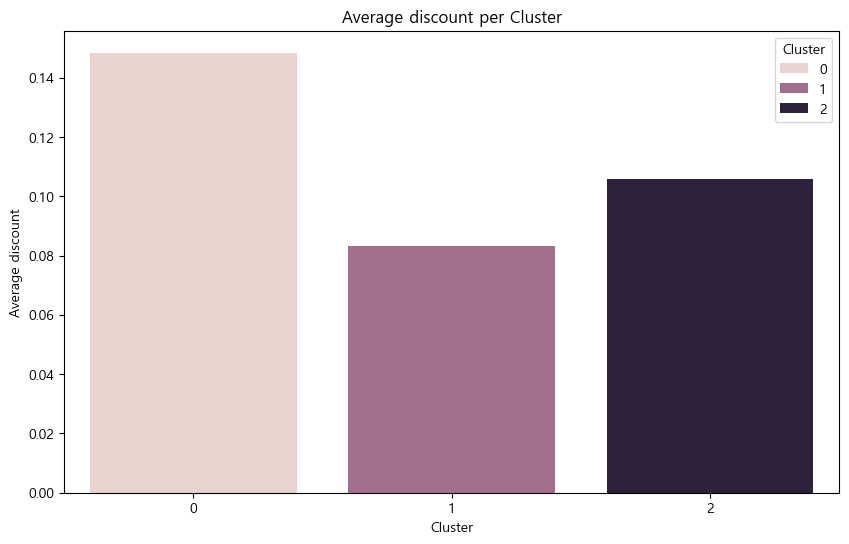

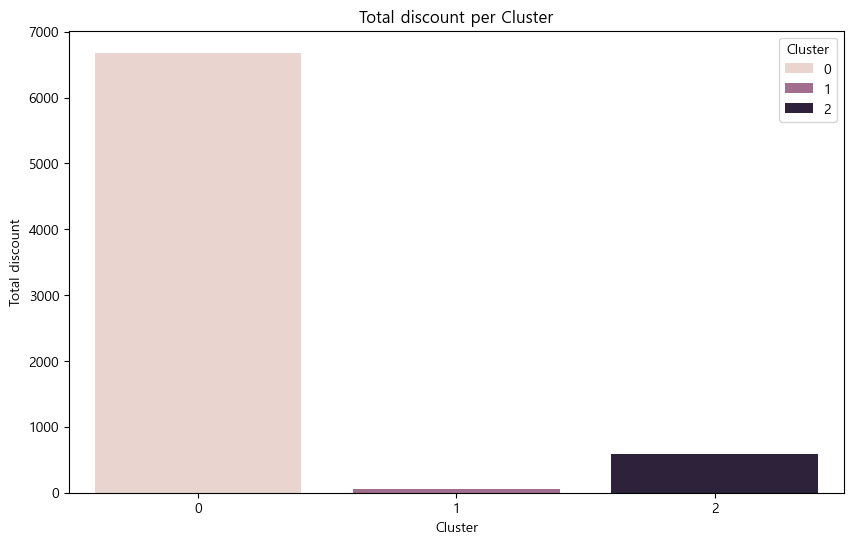

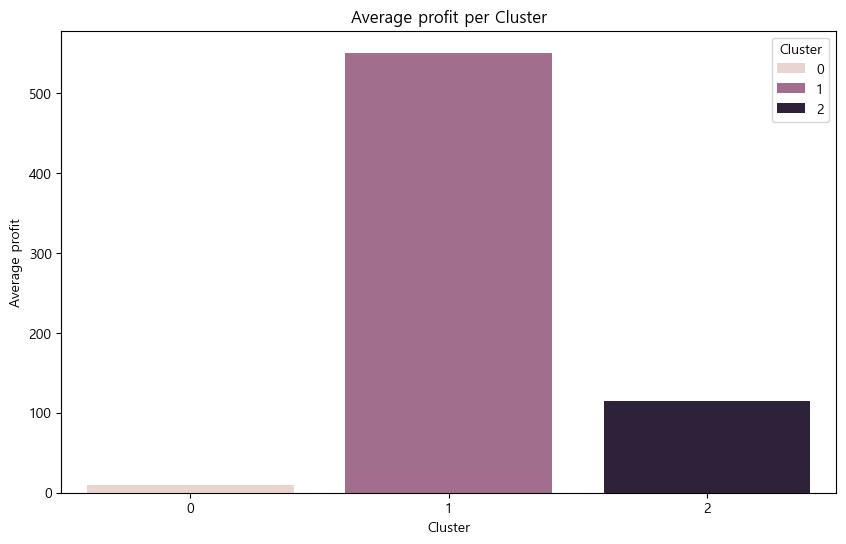

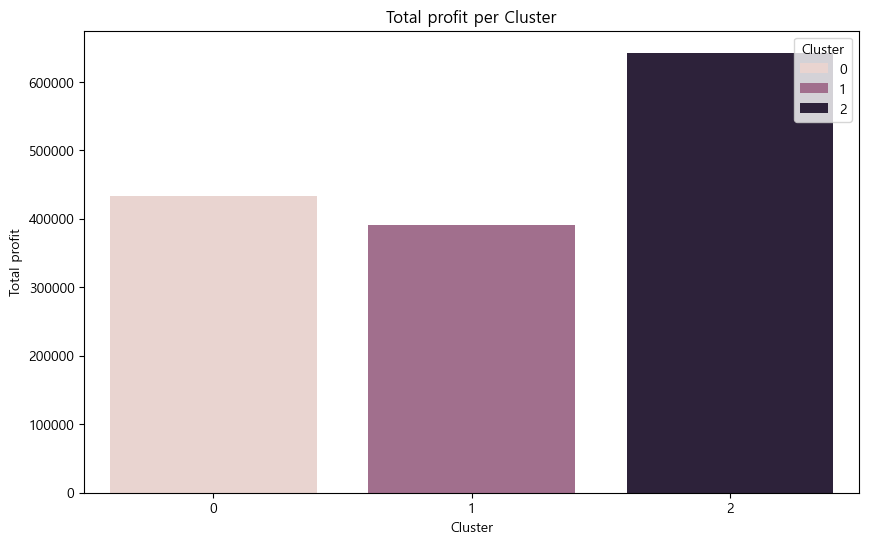

In [59]:
# 클러스터별로 sales의 평균과 합계 계산
cluster_sales_stats = df.groupby('Cluster')['sales'].agg(['mean', 'sum']).reset_index()

# 클러스터별로 quantity의 평균과 합계 계산
cluster_quantity_stats = df.groupby('Cluster')['quantity'].agg(['mean', 'sum']).reset_index()

# 클러스터별로 discount의 평균과 합계 계산
cluster_discount_stats = df.groupby('Cluster')['discount'].agg(['mean', 'sum']).reset_index()

# 클러스터별로 profit의 평균과 합계 계산
cluster_profit_stats = df.groupby('Cluster')['profit'].agg(['mean', 'sum']).reset_index()

# sales 평균에 대한 막대 그래프
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='mean', hue='Cluster', data=cluster_sales_stats, dodge=False)
plt.title('Average Sales per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Sales')
plt.legend(title='Cluster', loc='upper right')
plt.show()

# sales 합계에 대한 막대 그래프
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='sum', hue='Cluster', data=cluster_sales_stats, dodge=False)
plt.title('Total Sales per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Sales')
plt.legend(title='Cluster', loc='upper right')
plt.show()

# quantity 평균에 대한 막대 그래프
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='mean', hue='Cluster', data=cluster_quantity_stats, dodge=False)
plt.title('Average quantity per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average quantity')
plt.legend(title='Cluster', loc='upper right')
plt.show()

# quantity 합계에 대한 막대 그래프
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='sum', hue='Cluster', data=cluster_quantity_stats, dodge=False)
plt.title('Total quantity per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total quantity')
plt.legend(title='Cluster', loc='upper right')
plt.show()


# discount 평균에 대한 막대 그래프
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='mean', hue='Cluster', data=cluster_discount_stats, dodge=False)
plt.title('Average discount per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average discount')
plt.legend(title='Cluster', loc='upper right')
plt.show()

# discount 합계에 대한 막대 그래프
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='sum', hue='Cluster', data=cluster_discount_stats, dodge=False)
plt.title('Total discount per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total discount')
plt.legend(title='Cluster', loc='upper right')
plt.show()


# profit 평균에 대한 막대 그래프
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='mean', hue='Cluster', data=cluster_profit_stats, dodge=False)
plt.title('Average profit per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average profit')
plt.legend(title='Cluster', loc='upper right')
plt.show()

# profit 합계에 대한 막대 그래프
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='sum', hue='Cluster', data=cluster_profit_stats, dodge=False)
plt.title('Total profit per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total profit')
plt.legend(title='Cluster', loc='upper right')
plt.show()


RFM 데이터 예시:
  customer_id  recency  frequency  monetary
0   AA-103151        9          5    1445.0
1   AA-103152       14          7    6105.0
2   AA-103153      695          2     633.0
3   AA-103154      185          5    5565.0
4   AA-103751        7          4    2407.0
Explained Variance Ratio: [0.65440859 0.23934071]


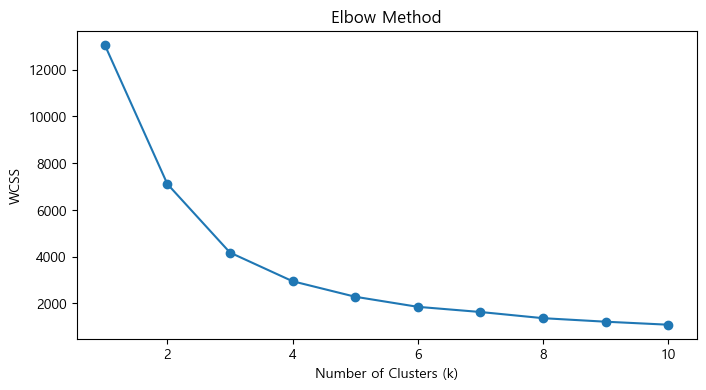

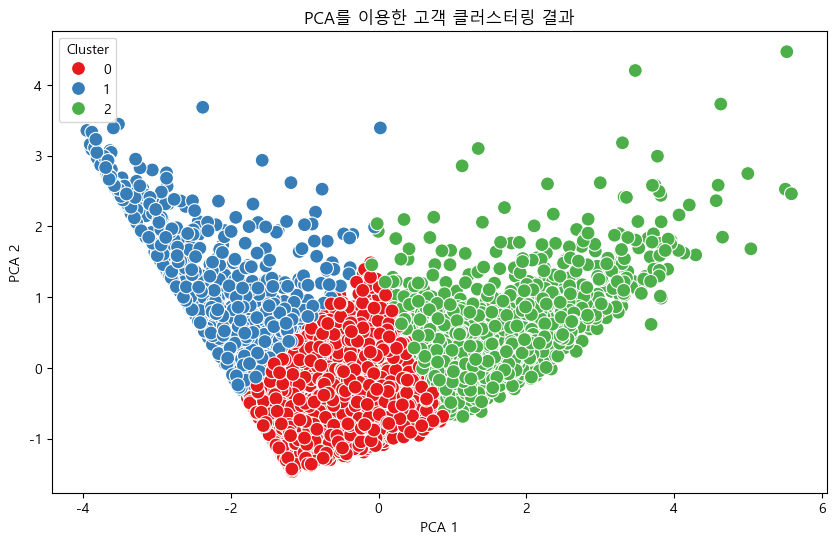


클러스터별 평균 RFM 값:
            recency  frequency     monetary
cluster                                    
0        140.067466   4.336582  1516.020615
1        721.982533   2.141194   799.173217
2         92.931489   8.374177  5302.457181


In [43]:
#  order_date를 datetime 형식으로 변환 (오류 발생 시 NaT 처리)
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

# 분석 기준 날짜 설정: 데이터 내 마지막 주문일 + 1일
analysis_date = df['order_date'].max() + pd.DateOffset(days=1)

# 고객별 RFM 지표 집계
# - Recency: 각 고객의 마지막 주문일과 기준 날짜 사이의 일수
# - Frequency: 고객별 고유 주문 건수 (order_id의 고유값 개수)
# - Monetary: 고객별 총 소비 금액 (sales 합계)
rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (analysis_date - x.max()).days,
    'order_id': 'nunique',
    'sales': 'sum'
}).rename(columns={
    'order_date': 'recency',
    'order_id': 'frequency',
    'sales': 'monetary'
}).reset_index()

print("RFM 데이터 예시:")
print(rfm.head())

# RFM 지표 스케일링 (recency, frequency, monetary)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])

# PCA 적용
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(rfm_scaled)
rfm['pca1'] = pca_result[:, 0]
rfm['pca2'] = pca_result[:, 1]

# PCA가 설명하는 분산 비율 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Elbow Method로 최적의 클러스터 수 탐색 (1~10개의 클러스터)
wcss = []
for k in range(1, 11):
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(pca_result)
    wcss.append(kmeans_temp.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.show()

# K-Means 클러스터링: 예시에서는 k=3을 선택
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['cluster'] = kmeans.fit_predict(pca_result)

# PCA 결과 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='pca1', y='pca2', hue='cluster', palette='Set1', s=100)
plt.title('PCA를 이용한 고객 클러스터링 결과')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

# 클러스터별 원본 RFM 지표 평균 확인
cluster_summary = rfm[['recency', 'frequency', 'monetary', 'cluster']].groupby('cluster').mean()
print("\n클러스터별 평균 RFM 값:")
print(cluster_summary)


Text(0.5, 0, 'sales')

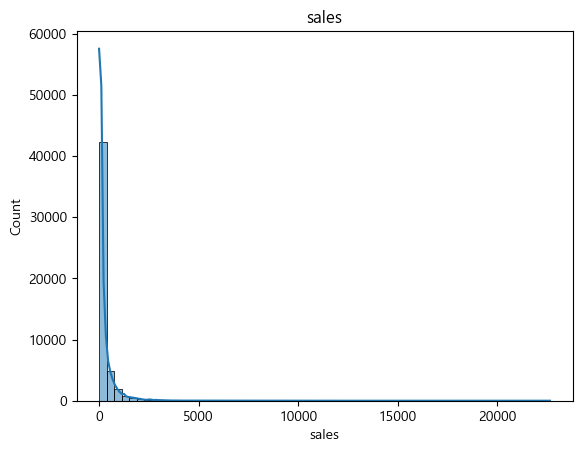

In [64]:
plt.plot(1, 2, 2)
sns.histplot(df['sales'], bins = 60, kde=True)
plt.title('sales')
plt.xlabel('sales')


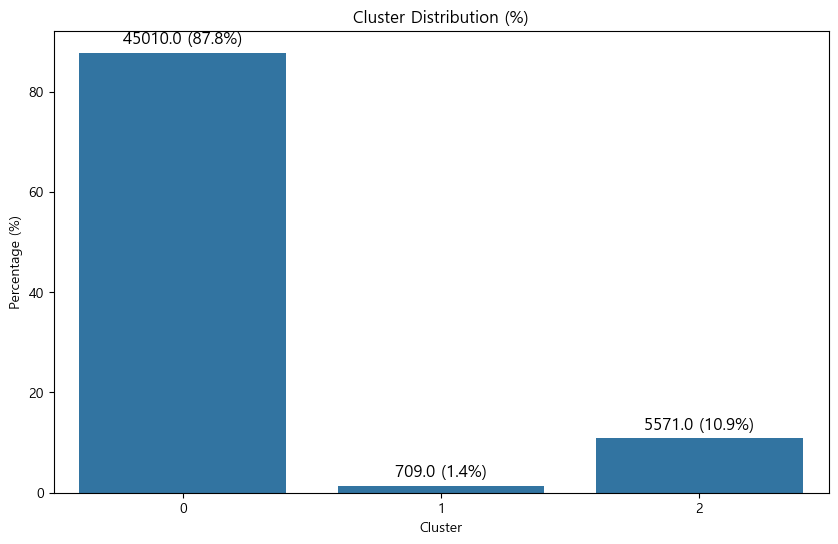

   Cluster  count  percentage
0        0  45010   87.755898
1        1    709    1.382336
2        2   5571   10.861766


In [50]:
# 클러스터별 개수를 그룹별로 계산 (groupby 사용)
cluster_counts = df.groupby('Cluster').size().reset_index(name='count')

# 전체 개수와 비율 계산
total_count = cluster_counts['count'].sum()
cluster_counts['percentage'] = (cluster_counts['count'] / total_count) * 100

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='percentage', data=cluster_counts)
plt.title('Cluster Distribution (%)')
plt.xlabel('Cluster')
plt.ylabel('Percentage (%)')

# 각 막대 위에 실제 개수와 비율 표시
for idx, row in cluster_counts.iterrows():
    plt.text(idx, row['percentage'] + 1, f"{row['count']} ({row['percentage']:.1f}%)", 
             ha='center', va='bottom', fontsize=12)

plt.show()

# 실제 값 출력
print(cluster_counts)
